# Injecting and Measuring Artificial Stars in Single-Visit Images

Based on a notebook by Jeff Carlin <br>
Last verified to run Monday, April 26, 2022, with weekly 2022_12.

Recommended container size: large (or possibly medium; small will definitely run out of memory and kill the kernel).


In [34]:
# Import python packages
import time
import os
import warnings
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from IPython.display import IFrame, display, Markdown
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.patches import Rectangle
from astropy.visualization import ZScaleInterval
from astropy.coordinates import SkyCoord
import astropy.units as u
from astropy.table import Table
import pandas as pd

%matplotlib inline

In [35]:
# Import tasks from the LSST Science Pipelines for reprocessing images
from lsst.pipe.tasks.characterizeImage import CharacterizeImageTask
from lsst.pipe.tasks.calibrate import CalibrateTask
from lsst.meas.algorithms.detection import SourceDetectionTask
from lsst.meas.deblender import SourceDeblendTask
from lsst.meas.base import SingleFrameMeasurementTask
import lsst.daf.base as dafBase
import lsst.sphgeom
import lsst.afw.display as afwDisplay
from lsst.geom import SpherePoint, Angle
from lsst.daf.butler import Butler
import lsst.afw.image as afwImage
import lsst.afw.table as afwTable
import lsst.geom as geom
import lsst.pipe.tasks.fakes as fakes
import warnings

# Use lsst.afw.display with the matplotlib backend
afwDisplay.setDefaultBackend('matplotlib')

In [36]:
# Set up some plotting defaults:

params = {'axes.labelsize': 28,
          'font.size': 24,
          'legend.fontsize': 14,
          'xtick.major.width': 3,
          'xtick.minor.width': 2,
          'xtick.major.size': 12,
          'xtick.minor.size': 6,
          'xtick.direction': 'in',
          'xtick.top': True,
          'lines.linewidth': 3,
          'axes.linewidth': 3,
          'axes.labelweight': 3,
          'axes.titleweight': 3,
          'ytick.major.width': 3,
          'ytick.minor.width': 2,
          'ytick.major.size': 12,
          'ytick.minor.size': 6,
          'ytick.direction': 'in',
          'ytick.right': True,
          'figure.figsize': [9, 9],
          'figure.facecolor': 'White'
          }

plt.rcParams.update(params)

#### Instantiate the Butler.

In [37]:
# For DC2 gen3, these are the only options
#repo = 's3://butler-us-central1-dp01'
#collection = '2.2i/runs/DP0.1'

butler = Butler('dp02', collections='2.2i/runs/DP0.2')
#butler = Butler(repo, collections=collection)
registry = butler.registry

#### Read in the lightcurves for the kilonovae and plot them
Once this has been done, it does not need to be repeated.

In [ ]:
fig, ax = plt.subplots(5, 4, figsize=(20, 20), sharey=False, sharex=False)

x = 0
for i in range(5):
    for j in range(4):
        
        filename = '~/KDC/notebooks/output/light_curve_'+str(x)+'.txt'
        outfile = pd.read_csv(filename)
        fine = outfile[outfile['u']>-9999]
        r = fine['r']
        g = fine['g']
        ii = fine['i']
        u = fine['u']
        z = fine['z']
        y = fine['y']
        timer = fine['time']
        
        ax[i,j].plot([-10,20],[24.03,24.03],'.k-')  #r
        ax[i,j].set_xlim(0,10)
        ax[i,j].plot(timer, r, '.r', label = "r")
        ax[i,j].plot(timer, g, '.g', label = "g") 
        ax[i,j].plot(timer, u, '.k', label = "u") 
        ax[i,j].plot(timer, ii, '.b', label = "i") 
        ax[i, j].xaxis.set_label_text('Days after KN')
        ax[i, j].invert_yaxis()
        ax[i, j].set_title('System '+str(x+1))
        x += 1

plt.tight_layout()
plt.show()

#### Pick out magnitudes at specific times and write them to a file

We pick out the magnitudes at times close to a known visit. Once this has been done, it does not need to be repeated.

In [ ]:
input_times = pd.read_csv('input/input_times.txt')
timer = input_times['tim']
magnitudes = pd.read_csv('output/magnitudes.txt')
ra = magnitudes['ra']
dec=magnitudes['dec']

for j in range(0,5):
    f = open('output/file_'+str(timer[j])+'.csv','w')
    header='ra,dec,u,g,r,i,z,y,time'
    f.write(header)
    f.write('\n')
    for i in range(0,20):
        filename = '~/KDC/notebooks/output/light_curve_'+str(i)+'.txt'
        outfile = pd.read_csv(filename)
        fine = outfile[outfile['time']==timer[j]]
        r = fine['r']
        g = fine['g']
        ii = fine['i']
        u = fine['u']
        z = fine['z']
        y = fine['y']
        timer = fine['time']
        outer = str(ra[i])+','+str(dec[i])+','+str(u.iloc[0])+','+str(g.iloc[0])+','+str(r.iloc[0])+','+str(ii.iloc[0])+','+str(z.iloc[0])+','+str(y.iloc[0])+','+str(timer.iloc[0])+'\n'
        f.write(outer)
    f.close()
f.close()

#### Read in the list of kilonovae and the center of the fields.

In [114]:
# Central (RA, Dec) position (in degrees) at which to insert stars:
#racen =  59.65688129
#deccen =  -36.75083078

data =pd.read_csv('output/file_0.05.csv')  #This is the file for 0.05 days after kilonova. This correspond to visit 1185205
#0.05
#1.05
#5.05
#6.85
#8.85

# Place all the fake stars within `scatter_arcmin` arcminutes of the center coordinate:
#scatter_arcmin = 1.0

# Assign positions using a (random) normal distribution about the center coordinates:
fake_id = data.index
fake_ras = data['ra']
fake_decs = data['dec']
fake_umags = data['u']
fake_gmags = data['g']
fake_rmags = data['r']
fake_imags = data['i']
fake_zmags = data['z']
fake_ymags = data['y']
fake_time = data['time']

racen =  fake_ras[12]
deccen =  fake_decs[12]

# "nfakes" is the number of fake stars to inject:
nfakes = len(fake_ras)


#### Here we make a plot of the positions of the fake kilonovae. We also overplot the center of the field as well as the locations of kilonovae that are in the current detector image (+ symbols).

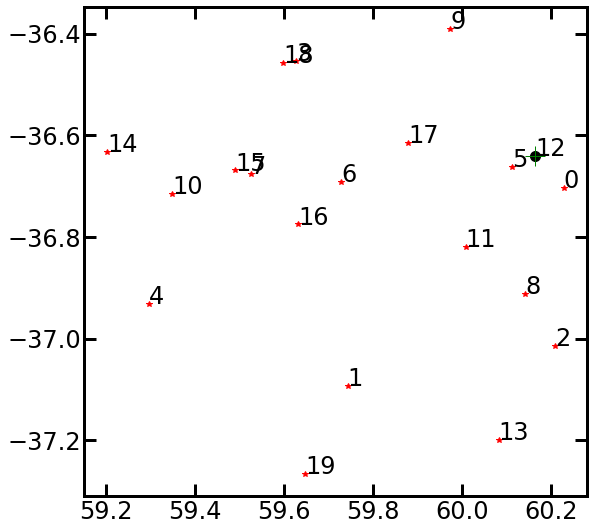

In [115]:
plt.plot(fake_ras, fake_decs, '*r')
for i, txt in enumerate(fake_ras):
    plt.annotate(fake_id[i], (fake_ras[i], fake_decs[i]))
plt.plot(racen, deccen,'.k-', markersize=20)
plt.plot(racen, deccen, '+g', markersize = 20)
#plt.plot(fake_ras[6], fake_decs[6], '+g', markersize = 20)
#plt.plot(fake_ras[7], fake_decs[7], '+g', markersize = 20)
#plt.plot(fake_ras[15], fake_decs[15], '+g', markersize = 20)
#plt.plot(fake_ras[16], fake_decs[16], '+g', markersize = 20)
#plt.plot(fake_ras[7], fake_decs[7], '+g', markersize = 20)
#plt.plot(fake_ras[16], fake_decs[16], '+g', markersize = 20)
plt.show()

In [116]:
import lsst.sphgeom

#Htm stands for Hierarchical Triangular mesh
#It breaks up a region of the sky into small triangular pieces
#Here is an SDSS explanation: http://www.skyserver.org/htm/
pixelization = lsst.sphgeom.HtmPixelization(12)

In [117]:
htm_id = pixelization.index(
    lsst.sphgeom.UnitVector3d(
        lsst.sphgeom.LonLat.fromDegrees(racen, deccen)
    )
)

# Obtain and print the scale to provide a sense of the size of the sky pixelization being used
scale = pixelization.triangle(htm_id).getBoundingCircle().getOpeningAngle().asDegrees()*3600
print(f'HTM ID={htm_id} at level={pixelization.getLevel()} is a ~{scale:0.2}" triangle.')

HTM ID=147190302 at level=12 is a ~6.7e+01" triangle.


In [118]:
#### This tells us how many calexps there are in each band at that position.

In [119]:
datasetRefs_u = registry.queryDatasets("calexp", htm20=htm_id, band="u")
datasetRefs_g = registry.queryDatasets("calexp", htm20=htm_id, band="g")
datasetRefs_r = registry.queryDatasets("calexp", htm20=htm_id, band="r")
datasetRefs_i = registry.queryDatasets("calexp", htm20=htm_id, band="i")
datasetRefs_z = registry.queryDatasets("calexp", htm20=htm_id, band="z")
datasetRefs_y = registry.queryDatasets("calexp", htm20=htm_id, band="y")

#print("Found ", datasetRefs_u.count(discard=True), " u-band calexps at that position.")
#print("Found ", datasetRefs_g.count(discard=True), " g-band calexps at that position.")
#print("Found ", datasetRefs_r.count(discard=True), " r-band calexps at that position.")
#print("Found ", datasetRefs_i.count(discard=True), " i-band calexps at that position.")
print("Found ", datasetRefs_u.count(), " u-band calexps at that position.")
print("Found ", datasetRefs_g.count(), " g-band calexps at that position.")
print("Found ", datasetRefs_r.count(), " r-band calexps at that position.")
print("Found ", datasetRefs_i.count(), " i-band calexps at that position.")
print("Found ", datasetRefs_z.count(), " z-band calexps at that position.")
print("Found ", datasetRefs_y.count(), " y-band calexps at that position.")

Found  48  u-band calexps at that position.
Found  66  g-band calexps at that position.
Found  172  r-band calexps at that position.
Found  156  i-band calexps at that position.
Found  85  z-band calexps at that position.
Found  108  y-band calexps at that position.


In [120]:
#dataId = {'visit': 1185205, 'detector': 82, 'band': 'r'} 
#calexp = butler.get('calexp', **dataId)


In [127]:
#fox = open('r_band.out', 'w')

for i, ref in enumerate(datasetRefs_r):
#for i in range(0,5):
    rref = ref
    if rref.dataId['visit'] == 1185205 and rref.dataId['detector'] == 43:
        final_rref = rref
        print(final_rref)
   # print((rref.dataId['visit']))
  #  print(rref)
  #  print(str(rref.dataId))
#    if i > datasetRefs_r.count():
#        break

#fox.close()

calexp@{instrument: 'LSSTCam-imSim', detector: 43, visit: 1185205, ...}, sc=ExposureF] (id=f535d0a9-e8db-46c2-a72e-841f328d68bb)


### Make stars and inject them into images:

First, write a function ("makeFakeStar") that takes as inputs the position, flux (intensity), and the PSF, and returns an image of the PSF scaled to the desired flux at the input position.

Next, we add a function ("addFakeStars") that takes the list of RAs, Decs, and magnitudes, and a `datasetRef` for a `calexp` image, and returns a version of the input `calexp` that has the fake stars injected into it. (This function calls "makeFakeStar" for each star in the list.)

The source injection steps were developed following this piece of code as an example: https://github.com/lsst/pipe_tasks/blob/387f8f07a2b66205f9fa6bda9a89dcdbbef3f64c/tests/test_fakeProcessing.py

In [128]:
print(final_rref)

calexp@{instrument: 'LSSTCam-imSim', detector: 43, visit: 1185205, ...}, sc=ExposureF] (id=f535d0a9-e8db-46c2-a72e-841f328d68bb)


In [129]:
# make stars at a given position with a given intensity
def makeFakeStar(position, intensity, psf):
    psfImage = psf.computeImage(geom.Point2D(position.x, position.y)).getArray()
    psfImage *= intensity
    noise = np.random.normal(0, np.sqrt(abs(psfImage)))
    return psfImage + noise, noise

In [130]:
def addFakeStars(ras, decs, mags, calexp_ref):
    calexp_inp = butler.get('calexp', calexp_ref.dataId)
    calexp_withFakes = calexp_inp.clone()

    # Fetch objects from the exposure
    psf = calexp_withFakes.getPsf()
    image = calexp_withFakes.getMaskedImage().getImage()
    variance = calexp_withFakes.getMaskedImage().getVariance()
    wcs = calexp_withFakes.getWcs()
    photocalib = calexp_withFakes.getPhotoCalib()

    fluxes = []

    # Use the "photocalib" from the calexp to convert magnitudes to instrumental fluxes:
    for mag in mags:
        fluxes.append(photocalib.magnitudeToInstFlux(mag))

    # Get the corner coordinates of the image:
    y0 = image.getY0()
    x0 = image.getX0()
    ymax = y0 + calexp_withFakes.getDimensions()[1]
    xmax = x0 + calexp_withFakes.getDimensions()[0]

    #xvals = []
    #yvals = []
    
    # At each position create a star with the given intensity and add it
    # to the image.
    for ra, dec, intensity in zip(ras, decs, fluxes):
        # Use the WCS to convert RA, Dec to X, Y pixel coordinates:
        pos = wcs.skyToPixel(geom.SpherePoint(ra, dec, geom.degrees))
        #xvals.append(pos.x)
        #yvals.append(pos.y)

        # Call "makeFakeStar" to get the image of a PSF-like object with the desired flux:
        objArray, noiseArray = makeFakeStar(pos, intensity, psf)
        psfRad = int((objArray.shape[0]-1)/2.)

        # Check that the desired position is within the image:
        oky = (pos.y > psfRad) & (pos.y < ymax - psfRad)
        okx = (pos.x > psfRad) & (pos.x < xmax - psfRad)

        if okx & oky:
            yslice = slice(int(np.floor(pos.y - psfRad - y0)), int(np.floor(pos.y + psfRad + y0 + 1)))
            xslice = slice(int(np.floor(pos.x - psfRad - x0)), int(np.floor(pos.x + psfRad + x0 + 1)))

            print('Injecting source at x, y = ', pos.x, pos.y)

            # NOTE: while image arrays are indexed with x, y, the extraction of the data into (numpy) arrays
            # means that the returned arrays follow numpy's y, x convention.
            # More on indexing: https://pipelines.lsst.io/modules/lsst.afw.image/indexing-conventions.html
            image.getArray()[yslice, xslice] += objArray
            variance.getArray()[yslice, xslice] += noiseArray**2
        else:
            print('Skipped injecting source at x, y = ', pos.x, pos.y, ' because it is too close to (or off) the edge.')

    return calexp_inp, calexp_withFakes

### Call the "addFakeStars" function to create calexp images with the artificial stars injected:

detector: 82, visit: 1185205 gets me 6 and 16
detector: 81, visit: 1185205 gets me 7

In [131]:
#calexp_orig_u, calexp_new_u = addFakeStars(fake_ras, fake_decs, fake_umags, uref)
#calexp_orig_g, calexp_new_g = addFakeStars(fake_ras, fake_decs, fake_gmags, gref)
calexp_orig_r, calexp_new_r = addFakeStars(fake_ras, fake_decs, fake_rmags, final_rref)
#calexp_orig_i, calexp_new_i = addFakeStars(fake_ras, fake_decs, fake_imags, iref)

Skipped injecting source at x, y =  4405.579884000669 -121.60771575444869  because it is too close to (or off) the edge.
Skipped injecting source at x, y =  6106.733842850737 9653.93273163867  because it is too close to (or off) the edge.
Skipped injecting source at x, y =  8811.581137949446 3358.2485966025724  because it is too close to (or off) the edge.
Skipped injecting source at x, y =  -4298.180027788595 4391.627064271658  because it is too close to (or off) the edge.
Skipped injecting source at x, y =  24.267812930009768 13240.140750387536  because it is too close to (or off) the edge.
Injecting source at x, y =  2826.787701871117 827.9922852827938
Skipped injecting source at x, y =  62.58047211968642 5653.652224201385  because it is too close to (or off) the edge.
Skipped injecting source at x, y =  -1862.0335019680422 7892.304503912182  because it is too close to (or off) the edge.
Skipped injecting source at x, y =  6756.999749446395 3094.467236583735  because it is too close

### Wrap all of the detection and measurement steps in a function.

The steps here follow the <a href="https://github.com/rubin-dp0/tutorial-notebooks/blob/main/05_Intro_to_Source_Detection.ipynb">Intro to Source Detection</a> tutorial notebook, so rather than explain them in detail here, we simply wrap all the steps in a single function that can be executed for each image.

In [73]:
def processFakes(calexp_inp):
    
    # Create a basic schema to use with these tasks
    schema = afwTable.SourceTable.makeMinimalSchema()

    # Create a container which will be used to record metadata about algorithm execution
    algMetadata = dafBase.PropertyList()

    # Initialize CharacterizeImageTask and its configuration:
    config = CharacterizeImageTask.ConfigClass()
    config.psfIterations = 1
    charImageTask = CharacterizeImageTask(None, config=config)

    # Initialize SourceDetectionTask and its configuration:
    config = SourceDetectionTask.ConfigClass()
    config.thresholdValue = 10      # detection threshold in units of thresholdType
    config.thresholdType = "stdev"   # units for thresholdValue
    sourceDetectionTask = SourceDetectionTask(schema=schema, config=config)
    sourceDeblendTask = SourceDeblendTask(schema=schema)

    # Initialize SingleFrameMeasurementTask and its configuration:
    config = SingleFrameMeasurementTask.ConfigClass()
    sourceMeasurementTask = SingleFrameMeasurementTask(schema=schema, config=config, algMetadata=algMetadata)

    # Make an empty table that we'll put the results in:
    tab = afwTable.SourceTable.make(schema)
    
    # Image characterization
    result = charImageTask.run(calexp_inp)

    # Get the PSF and some image properties
    psf = calexp_inp.getPsf()
    sigma = psf.computeShape().getDeterminantRadius()
    pixelScale = calexp_inp.getWcs().getPixelScale().asArcseconds()

    # The factor of 2.355 converts from std to fwhm
    print('psf fwhm = {:.2f} arcsec'.format(sigma*pixelScale*2.355))
    
    # Run source detection
    result = sourceDetectionTask.run(tab, calexp_inp)
    
    sources = result.sources
    
    # Run source deblending
    sourceDeblendTask.run(calexp_inp, sources)

    # Run source measurement
    sourceMeasurementTask.run(measCat=sources, exposure=calexp_inp)

    # The copy makes sure that the sources are sequential in memory
    sources = sources.copy(True)
    
    # For convenience, return an Astropy table:
    source_tab = sources.asAstropy()
    
    # Convert fluxes to magnitudes and add them to the table
    photocalib = calexp_inp.getPhotoCalib()
    psfmags = photocalib.instFluxToMagnitude(sources, 'base_PsfFlux')
    source_tab.add_columns([psfmags[:,0], psfmags[:,1]], names=['mag_psf', 'magerr_psf'])
    
    return(source_tab)

### Run the "processFakes" function on each image that we injected fake stars into

**This may take at least a couple minutes to run**

In [49]:
t1 = time.time()

#sources_withfakes_u = processFakes(calexp_new_u)
#sources_withfakes_g = processFakes(calexp_new_g)
sources_withfakes_r = processFakes(calexp_new_r)
#sources_withfakes_i = processFakes(calexp_new_i)

t2 = time.time()
print('dt', t2 - t1)

/opt/lsst/software/stack/stack/miniconda3-py38_4.9.2-3.0.0/Linux64/meas_algorithms/gbe01a4569f+b284e5e768/python/lsst/meas/algorithms/installGaussianPsf.py:77: FutureWarning: Default position argument overload is deprecated and will be removed in version 24.0.  Please explicitly specify a position.
  psfSigma = psfModel.computeShape().getDeterminantRadius()
/opt/lsst/software/stack/stack/miniconda3-py38_4.9.2-3.0.0/Linux64/meas_algorithms/gbe01a4569f+b284e5e768/python/lsst/meas/algorithms/installGaussianPsf.py:78: FutureWarning: Default position argument overload is deprecated and will be removed in version 24.0.  Please explicitly specify a position.
  width, height = psfModel.computeImage().getDimensions()


/opt/lsst/software/stack/stack/miniconda3-py38_4.9.2-3.0.0/Linux64/meas_algorithms/gbe01a4569f+b284e5e768/python/lsst/meas/algorithms/detection.py:410: FutureWarning: Default position argument overload is deprecated and will be removed in version 24.0.  Please explicitly specify a position.
  sigma = psf.computeShape().getDeterminantRadius()
/opt/lsst/software/stack/stack/miniconda3-py38_4.9.2-3.0.0/Linux64/meas_algorithms/gbe01a4569f+b284e5e768/python/lsst/meas/algorithms/detection.py:447: FutureWarning: Default position argument overload is deprecated and will be removed in version 24.0.  Please explicitly specify a position.
  sigma = psf.computeShape().getDeterminantRadius()


/tmp/ipykernel_766/125701312.py:33: FutureWarning: Default position argument overload is deprecated and will be removed in version 24.0.  Please explicitly specify a position.
  sigma = psf.computeShape().getDeterminantRadius()
/opt/lsst/software/stack/stack/miniconda3-py38_4.9.2-3.0.0/Linux64/meas_algorithms/gbe01a4569f+b284e5e768/python/lsst/meas/algorithms/detection.py:410: FutureWarning: Default position argument overload is deprecated and will be removed in version 24.0.  Please explicitly specify a position.
  sigma = psf.computeShape().getDeterminantRadius()
/opt/lsst/software/stack/stack/miniconda3-py38_4.9.2-3.0.0/Linux64/meas_algorithms/gbe01a4569f+b284e5e768/python/lsst/meas/algorithms/detection.py:447: FutureWarning: Default position argument overload is deprecated and will be removed in version 24.0.  Please explicitly specify a position.
  sigma = psf.computeShape().getDeterminantRadius()


psf fwhm = 0.68 arcsec


/opt/lsst/software/stack/stack/miniconda3-py38_4.9.2-3.0.0/Linux64/meas_deblender/g359a236c20+bf72eb646d/python/lsst/meas/deblender/sourceDeblendTask.py:281: FutureWarning: Default position argument overload is deprecated and will be removed in version 24.0.  Please explicitly specify a position.
  return psf.computeShape().getDeterminantRadius() * 2.35


dt 20.669852256774902


In [50]:
# Take a look at the catalog:

sources_withfakes_r

id,coord_ra,coord_dec,parent,deblend_nChild,deblend_deblendedAsPsf,deblend_psfCenter_x,deblend_psfCenter_y,deblend_psf_instFlux,deblend_tooManyPeaks,deblend_parentTooBig,deblend_masked,deblend_skipped,deblend_rampedTemplate,deblend_patchedTemplate,deblend_hasStrayFlux,deblend_peak_center_x,deblend_peak_center_y,deblend_peakId,deblend_nPeaks,deblend_parentNPeaks,base_NaiveCentroid_x,base_NaiveCentroid_y,base_NaiveCentroid_flag,base_NaiveCentroid_flag_noCounts,base_NaiveCentroid_flag_edge,base_NaiveCentroid_flag_resetToPeak,base_SdssCentroid_x,slot_Centroid_x,base_SdssCentroid_y,slot_Centroid_y,base_SdssCentroid_xErr,slot_Centroid_xErr,base_SdssCentroid_yErr,slot_Centroid_yErr,base_SdssCentroid_flag,base_CircularApertureFlux_flag_badCentroid,base_GaussianFlux_flag_badCentroid,base_LocalBackground_flag_badCentroid,base_NaiveCentroid_flag_badInitialCentroid,base_PsfFlux_flag_badCentroid,base_SdssShape_flag_badCentroid,base_Variance_flag_badCentroid,slot_Centroid_flag,base_SdssCentroid_flag_edge,base_CircularApertureFlux_flag_badCentroid_edge,base_GaussianFlux_flag_badCentroid_edge,base_LocalBackground_flag_badCentroid_edge,base_NaiveCentroid_flag_badInitialCentroid_edge,base_PsfFlux_flag_badCentroid_edge,base_SdssShape_flag_badCentroid_edge,base_Variance_flag_badCentroid_edge,slot_Centroid_flag_edge,base_SdssCentroid_flag_noSecondDerivative,base_CircularApertureFlux_flag_badCentroid_noSecondDerivative,base_GaussianFlux_flag_badCentroid_noSecondDerivative,base_LocalBackground_flag_badCentroid_noSecondDerivative,base_NaiveCentroid_flag_badInitialCentroid_noSecondDerivative,base_PsfFlux_flag_badCentroid_noSecondDerivative,base_SdssShape_flag_badCentroid_noSecondDerivative,base_Variance_flag_badCentroid_noSecondDerivative,slot_Centroid_flag_noSecondDerivative,base_SdssCentroid_flag_almostNoSecondDerivative,base_CircularApertureFlux_flag_badCentroid_almostNoSecondDerivative,base_GaussianFlux_flag_badCentroid_almostNoSecondDerivative,base_LocalBackground_flag_badCentroid_almostNoSecondDerivative,base_NaiveCentroid_flag_badInitialCentroid_almostNoSecondDerivative,base_PsfFlux_flag_badCentroid_almostNoSecondDerivative,base_SdssShape_flag_badCentroid_almostNoSecondDerivative,base_Variance_flag_badCentroid_almostNoSecondDerivative,slot_Centroid_flag_almostNoSecondDerivative,base_SdssCentroid_flag_notAtMaximum,base_CircularApertureFlux_flag_badCentroid_notAtMaximum,base_GaussianFlux_flag_badCentroid_notAtMaximum,base_LocalBackground_flag_badCentroid_notAtMaximum,base_NaiveCentroid_flag_badInitialCentroid_notAtMaximum,base_PsfFlux_flag_badCentroid_notAtMaximum,base_SdssShape_flag_badCentroid_notAtMaximum,base_Variance_flag_badCentroid_notAtMaximum,slot_Centroid_flag_notAtMaximum,base_SdssCentroid_flag_resetToPeak,base_CircularApertureFlux_flag_badCentroid_resetToPeak,base_GaussianFlux_flag_badCentroid_resetToPeak,base_LocalBackground_flag_badCentroid_resetToPeak,base_NaiveCentroid_flag_badInitialCentroid_resetToPeak,base_PsfFlux_flag_badCentroid_resetToPeak,base_SdssShape_flag_badCentroid_resetToPeak,base_Variance_flag_badCentroid_resetToPeak,slot_Centroid_flag_resetToPeak,base_SdssCentroid_flag_badError,base_CircularApertureFlux_flag_badCentroid_badError,base_GaussianFlux_flag_badCentroid_badError,base_LocalBackground_flag_badCentroid_badError,base_NaiveCentroid_flag_badInitialCentroid_badError,base_PsfFlux_flag_badCentroid_badError,base_SdssShape_flag_badCentroid_badError,base_Variance_flag_badCentroid_badError,slot_Centroid_flag_badError,base_Blendedness_old,base_Blendedness_raw,base_Blendedness_raw_child_instFlux,base_Blendedness_raw_parent_instFlux,base_Blendedness_abs,base_Blendedness_abs_child_instFlux,base_Blendedness_abs_parent_instFlux,base_Blendedness_raw_child_xx,base_Blendedness_raw_child_yy,base_Blendedness_raw_child_xy,base_Blendedness_raw_parent_xx,base_Blendedness_raw_parent_yy,base_Blendedness_raw_parent_xy,base_Blendedness_abs_child_xx,base_Blendedness_abs_child_yy,base_Blendedness_abs_child_xy,base_Blendedness_abs_parent_x

### Match coordinates from the original list of fake stars to the new catalog:

In [51]:
# Coordinates of input fake stars
sc_fakes = SkyCoord(ra=fake_ras*u.deg, dec=fake_decs*u.deg, frame='icrs')

# Coordinates of objects in calexps with fakes added:
#sc_withfakes_u = SkyCoord(ra=sources_withfakes_u['coord_ra'], dec=sources_withfakes_u['coord_dec'], frame='icrs')
#sc_withfakes_g = SkyCoord(ra=sources_withfakes_g['coord_ra'], dec=sources_withfakes_g['coord_dec'], frame='icrs')
sc_withfakes_r = SkyCoord(ra=sources_withfakes_r['coord_ra'], dec=sources_withfakes_r['coord_dec'], frame='icrs')
#sc_withfakes_i = SkyCoord(ra=sources_withfakes_i['coord_ra'], dec=sources_withfakes_i['coord_dec'], frame='icrs')
# Note that units weren't required for sc_withfakes_*, because it already has them.

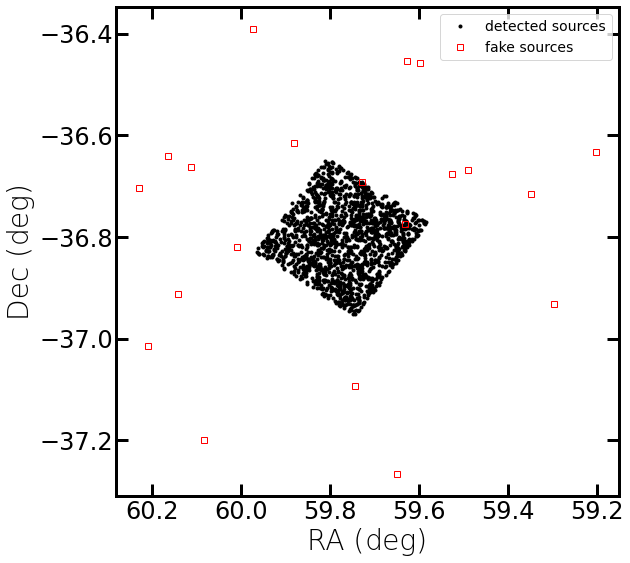

In [52]:
fig, ax = plt.subplots(1, 1)
plt.plot(sc_withfakes_r.ra, sc_withfakes_r.dec, '.k', label='detected sources')
plt.plot(sc_fakes.ra, sc_fakes.dec, 'sr', fillstyle='none', label='fake sources')
ax.invert_xaxis()
plt.legend()
plt.xlabel('RA (deg)')
plt.ylabel('Dec (deg)')
plt.show()

In [53]:
# Match them using the Astropy SkyCoord "match_to_catalog_sky" method:

#idx_u, sep_u, _ = sc_fakes.match_to_catalog_sky(sc_withfakes_u)
#idx_g, sep_g, _ = sc_fakes.match_to_catalog_sky(sc_withfakes_g)
idx_r, sep_r, _ = sc_fakes.match_to_catalog_sky(sc_withfakes_r)
#idx_i, sep_i, _ = sc_fakes.match_to_catalog_sky(sc_withfakes_i)

The "idx*" arrays are the indices into sc_withfakes* files to extract the closest match, and "sep*" are the actual separations between the sources. Note that this returns a separation for all objects -- in the following, we will keep only sources with match separations less than 1 arcsecond (i.e., "good" matches).

Extract info about the good matches into arrays:

In [54]:
okmch_r = (sep_r.arcsec < 1.0)
mch_mags_r = sources_withfakes_r[idx_r]['mag_psf']
mch_magerrs_r = sources_withfakes_r[idx_r]['magerr_psf']
mch_mags_r[~okmch_r] = -99.9
mch_magerrs_r[~okmch_r] = 99.9
seps_r = sep_r.arcsec



#print(fake_imags[okmch], sources_withfakes_i[idx_i[okmch]]['mag_psf'])

In [55]:
sep_r.arcsec

array([8.81915760e+02, 5.10804478e+02, 9.69433924e+02, 8.64099184e+02,
       1.00826866e+03, 6.91949155e+02, 2.32553538e-02, 3.74442516e+02,
       5.92707628e+02, 1.04370254e+03, 7.10236667e+02, 1.34940635e+02,
       8.61134734e+02, 1.28042598e+03, 1.20674643e+03, 4.53697928e+02,
       2.19916346e-03, 2.38431816e+02, 8.96133888e+02, 1.16816727e+03])

Combine all of the information into a single table:

In [57]:
tab_all = Table([fake_ras, fake_decs, fake_umags, fake_gmags, fake_rmags, fake_imags,
                 mch_mags_u, mch_magerrs_u, seps_u, mch_mags_g, mch_magerrs_g, seps_g,
                 mch_mags_r, mch_magerrs_r, seps_r, mch_mags_i, mch_magerrs_i, seps_i],
                 names=['ra', 'dec', 'u_fake', 'g_fake', 'r_fake', 'i_fake', 'u_meas', 'uerr_meas', 'sep_u',
                        'g_meas', 'gerr_meas', 'sep_g', 'r_meas', 'rerr_meas', 'sep_r',
                        'i_meas', 'ierr_meas', 'sep_i'],
                 units=[u.deg, u.deg, u.mag, u.mag, u.mag, u.mag, u.mag, u.mag, u.arcsec,
                        u.mag, u.mag, u.arcsec, u.mag, u.mag, u.arcsec, u.mag, u.mag, u.arcsec])

for col in tab_all.colnames[0:2]:
    tab_all[col].info.format = '%.8g'  # for consistent table output
for col in tab_all.colnames[2:]:
    tab_all[col].info.format = '%.5g'  # for consistent table output


NameError: name 'mch_mags_u' is not defined

In [ ]:
tab_all

Now we have completed all the steps of injecting fake sources, running pipeline tasks to detect and measure all sources in the resulting images, and extracting the matches from the catalogs. Let's look at the results!

Compare the "fake" magnitudes we assigned to each star to their output (measured) magnitude:

In [ ]:
fig = plt.plot(figsize=(9, 9))

plt.hlines(0, 0, 30, linestyle=':', color='Black')
plt.plot(tab_all['r_fake'], 1000.0 * (tab_all['r_meas'] - tab_all['r_fake']),
         '*', ms=10, color='firebrick', label='r')
plt.legend()
plt.xlabel(r'$mag_{\rm fake}$')
plt.ylabel(r'$(mag_{\rm meas} - mag_{\rm fake})$ (mmag)')
#plt.xlim(15.2, 23.3)
#plt.ylim(-48, 48)
plt.minorticks_on()
plt.show()

Looks good! (Note that the y-axis is showing residuals in _millimags_.)

In [58]:
afwDisplay.setDefaultBackend('firefly')

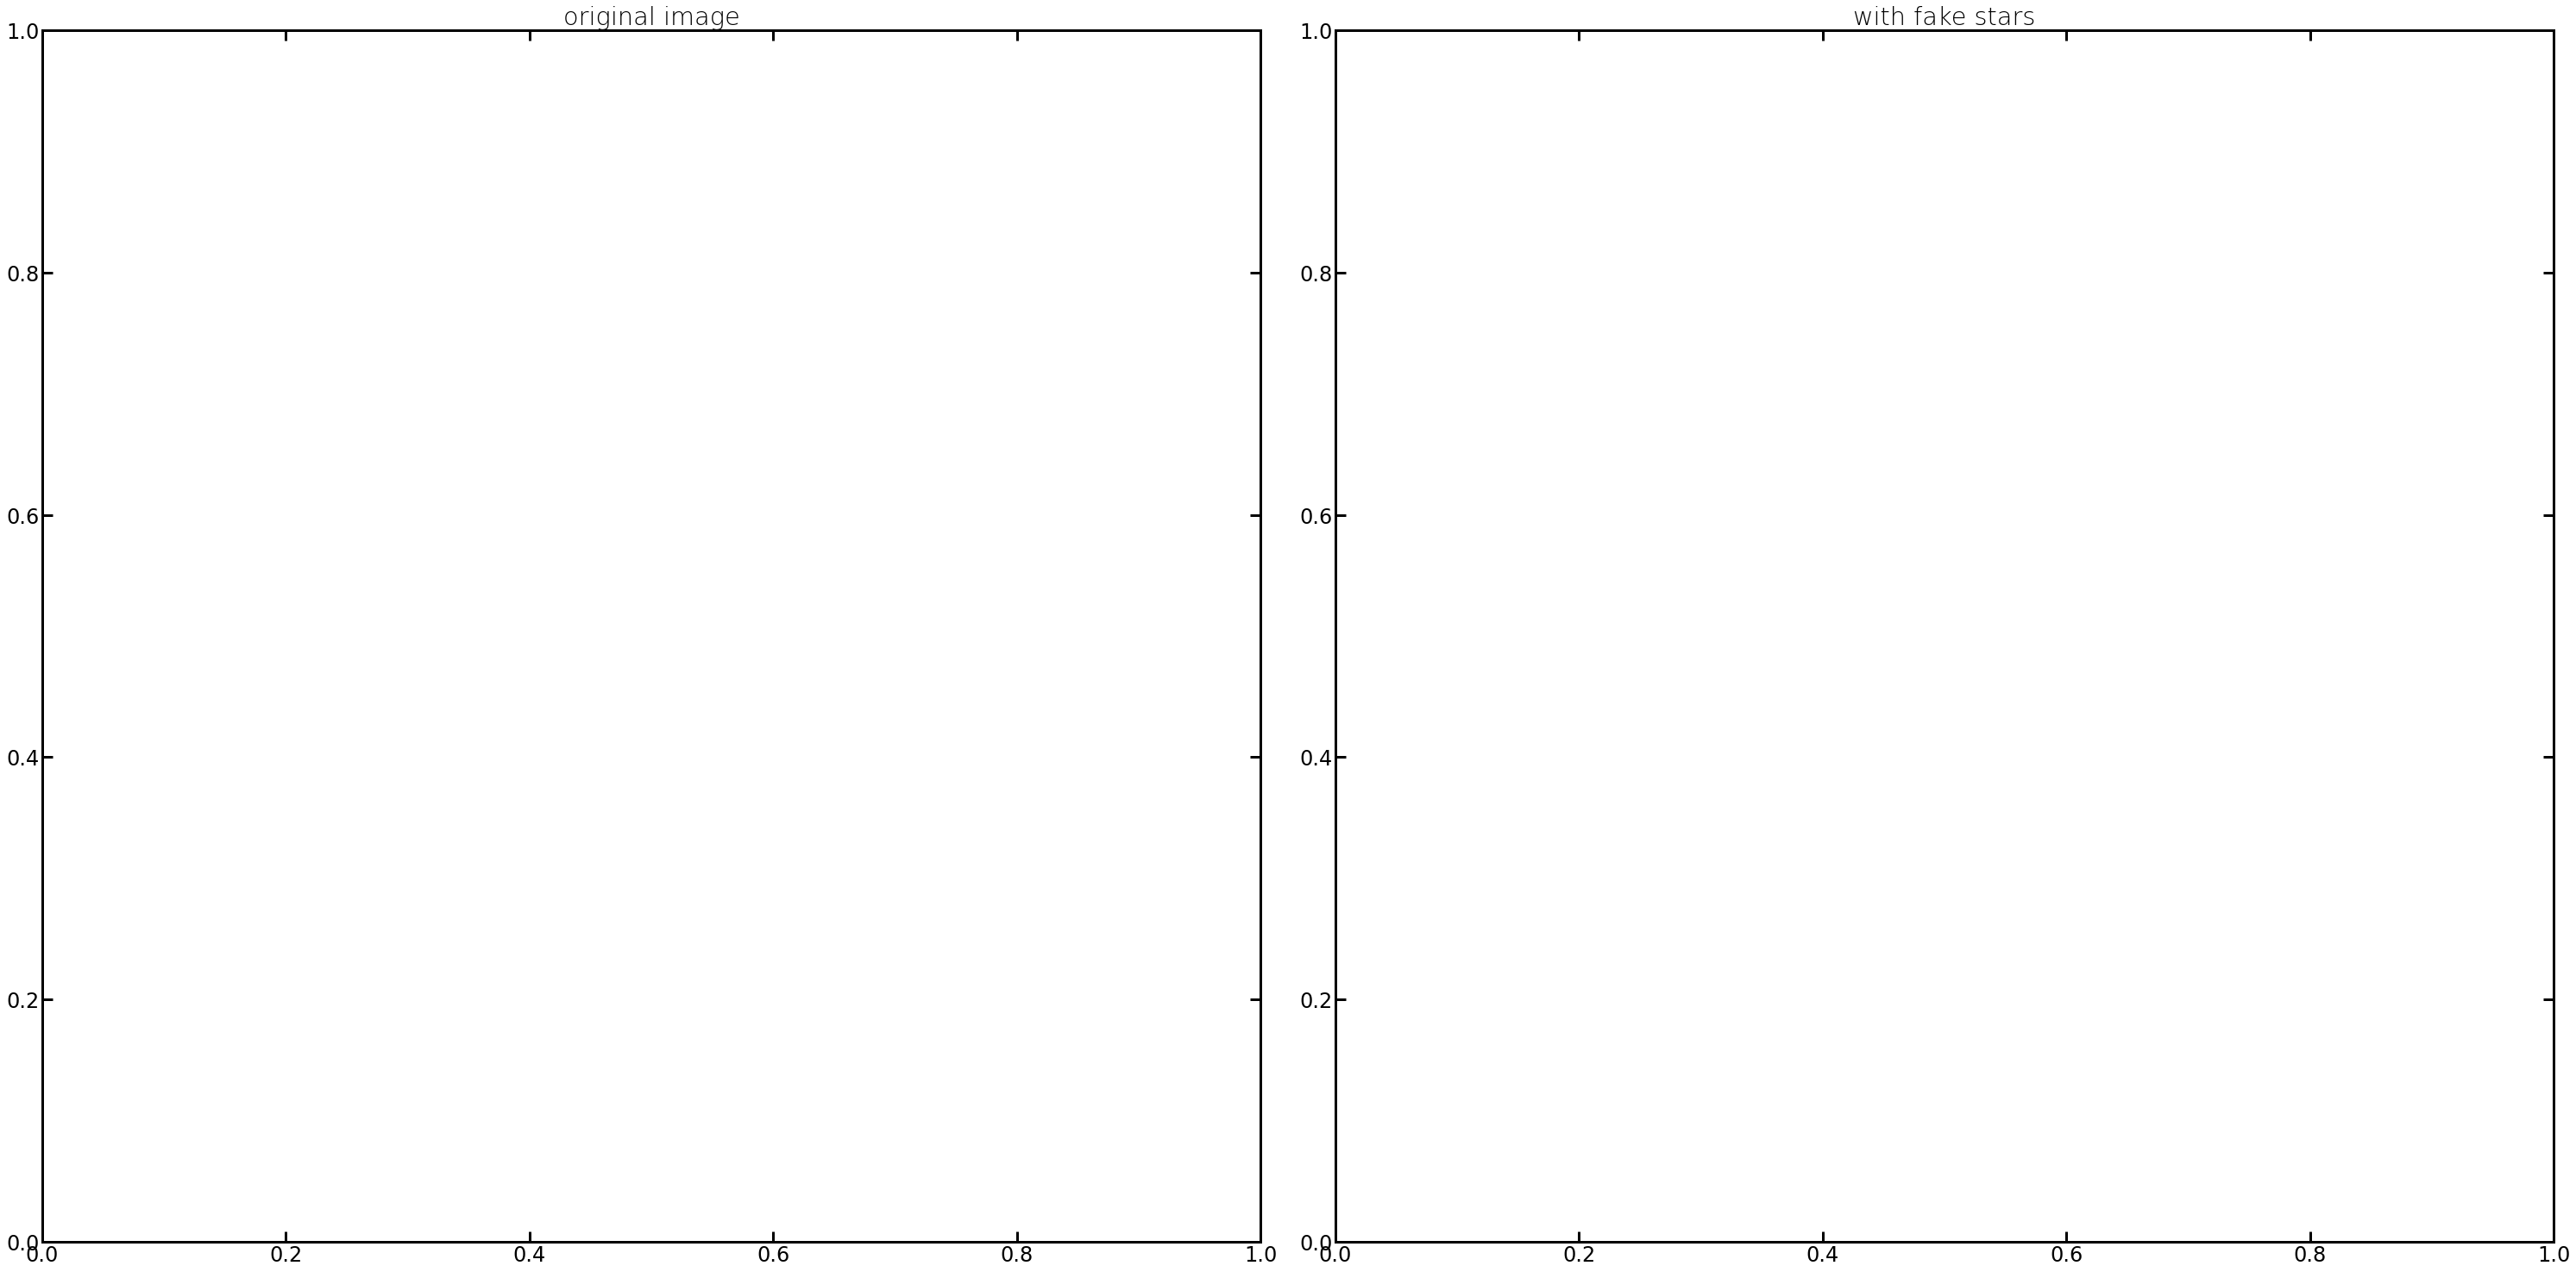

In [59]:
from astropy.io import fits

fig, ax = plt.subplots(1, 2, figsize=(14*3, 7*3))
plt.sca(ax[0])  # set the first axis as current
display1 = afwDisplay.Display(frame=fig)
display1.scale('linear', 'zscale')
#afw_display = afwDisplay.Display(frame=1)
display1.mtv(calexp_orig_r.image)

#outfile = 'calexp_orig.fits'
#hdu = fits.PrimaryHDU(calexp_orig_g.image)
#hdu.writeto(outfile, overwrite=True)

plt.title('original image')
#plt.xlim(1000, 2500)
#plt.ylim(300, 1800)
plt.sca(ax[1])  # set the second axis as current

display2 = afwDisplay.Display(frame=fig)
radec = SpherePoint(fake_ras[0], fake_decs[0], lsst.geom.degrees)
#radec2 = SpherePoint(fake_ras[7], fake_decs[7], lsst.geom.degrees)
#radec3 = SpherePoint(fake_ras[16], fake_decs[16], lsst.geom.degrees)
xy = calexp_new_r.getWcs().skyToPixel(radec)
#xy2 = calexp_new_g.getWcs().skyToPixel(radec2)
#xy3 = calexp_new_g.getWcs().skyToPixel(radec3)
display2.scale('linear', 'zscale')
#display2.mtv(calexp_new_g.image)
display2.mtv(calexp_orig_r.image)
display2.dot('o', xy.getX(), xy.getY(), ctype='red', size = 20)
#display2.dot('o', xy2.getX(), xy2.getY(), ctype='red', size = 20)
#display2.dot('o', xy3.getX(), xy3.getY(), ctype='red', size = 20)



# display2.mtv(image0)
plt.title('with fake stars')
#plt.xlim(1000, 2500)
#plt.ylim(300, 1800)
plt.tight_layout()
plt.show()

Ideas for further exploration:

- Inject stars using a realistic stellar population (i.e., get colors and a luminosity function from isochrones).
- Inject galaxies or other objects.
- Inject periodic variables into a set of overlapping visit images (using their time of observation to determine the input phase, and thus magnitude, for each image).
- Test completeness of detection/measurement (will need to inject stars over a variety of magnitudes and colors, and probably many times over to build up a large enough statistical sample).


In [ ]:

fig, ax = plt.subplots(1, 1, figsize=(14*3, 7*3))
radec = SpherePoint(fake_ras[0], fake_decs[0], lsst.geom.degrees)
xy = geom.PointI(calexp_new_g.getWcs().skyToPixel(radec))
cutoutSideLength = 51
cutoutSize = geom.ExtentI(cutoutSideLength, cutoutSideLength)

bbox = geom.BoxI(xy - cutoutSize // 2, cutoutSize)
 
display1 = afwDisplay.Display(frame=fig)
display1.scale('linear', 'zscale')
display1.mtv(calexp_new_g.image)


In [ ]:
display1.mtv.help